# Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import multiprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf
import tensorflow
from tensorflow.keras.utils import to_categorical
import pickle
import catboost as cb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [2]:
global rand_state
rand_state = 2023

# Utility Functions

In [3]:
def get_mean_cvs(model, X, y):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    
    print(f'Cross Validation Accuracy Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels, 
                                digits=3))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='accuracy', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [133]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv').to_numpy().ravel()

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv').to_numpy().ravel()

# Scaling Data

In [134]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Probabilistic

## Logistic Regression

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.479 (0.024)
                precision    recall  f1-score   support

   High Shares      0.393     0.279     0.326       283
Average Shares      0.507     0.596     0.548       245
    Low Shares      0.487     0.557     0.520       271

      accuracy                          0.471       799
     macro avg      0.462     0.477     0.465       799
  weighted avg      0.460     0.471     0.460       799



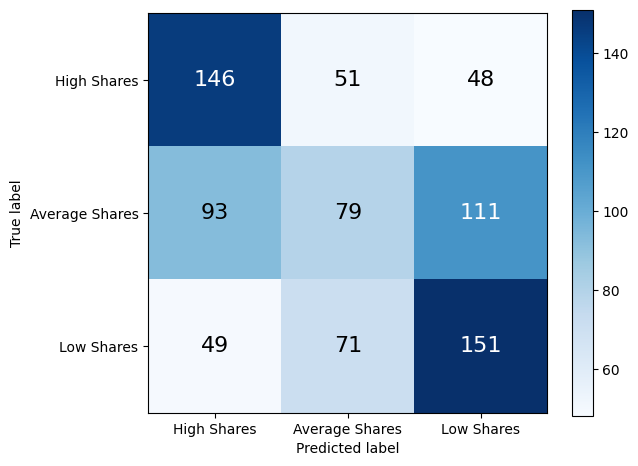

In [6]:
lr_base_model = LogisticRegression(max_iter=1000, random_state=rand_state)
print(lr_base_model.get_params())

get_mean_cvs(lr_base_model, X_train_scaled, y_train)

lr_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = lr_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 2023, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.479 (0.023)
                precision    recall  f1-score   support

   High Shares      0.387     0.272     0.320       283
Average Shares      0.503     0.592     0.544       245
    Low Shares      0.487     0.561     0.521       271

      accuracy                          0.468       799
     macro avg      0.459     0.475     0.462       799
  weighted avg      0.457     0.468     0.457       799



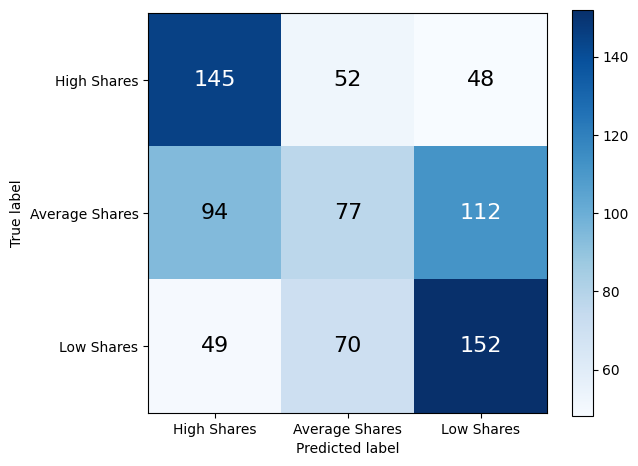

In [7]:
lr_GS = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=rand_state), 
    {
        'C': [0.1, 1, 10], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lr_GS = lr_GS.fit(X_train_scaled, y_train)

lr_best_model = lr_GS.best_estimator_
print(lr_best_model.get_params())

get_mean_cvs(lr_best_model, X_train_scaled, y_train)

lr_best_model.fit(X_train_scaled, y_train)
y_pred_lr_best = lr_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [8]:
pickle.dump(lr_best_model, open('./dataset/Model/lr_best_model.pkl', 'wb'))

## Naive Bayes

{'priors': None, 'var_smoothing': 1e-09}
Cross Validation Accuracy Score: 0.367 (0.013)
                precision    recall  f1-score   support

   High Shares      0.000     0.000     0.000       283
Average Shares      0.324     0.980     0.487       245
    Low Shares      0.569     0.122     0.201       271

      accuracy                          0.342       799
     macro avg      0.298     0.367     0.229       799
  weighted avg      0.292     0.342     0.217       799



/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/PoYan1/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


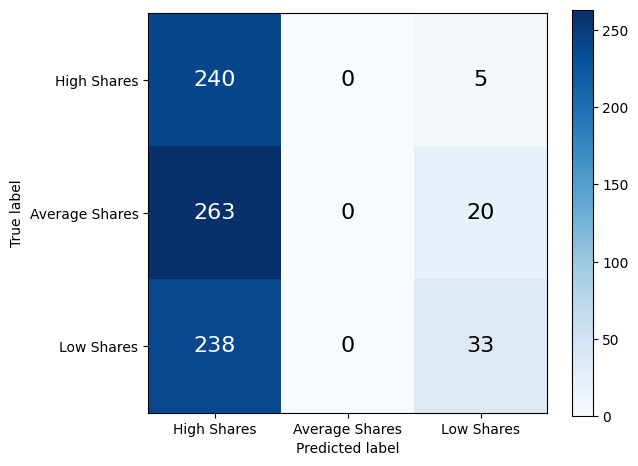

In [9]:
nb_base_model = GaussianNB()
print(nb_base_model.get_params())

get_mean_cvs(nb_base_model, X_train_scaled, y_train)

nb_base_model.fit(X_train_scaled, y_train)
y_pred_nb_base = nb_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_nb_base)

{'priors': None, 'var_smoothing': 0.01}
Cross Validation Accuracy Score: 0.453 (0.022)
                precision    recall  f1-score   support

   High Shares      0.387     0.272     0.320       283
Average Shares      0.503     0.592     0.544       245
    Low Shares      0.487     0.561     0.521       271

      accuracy                          0.468       799
     macro avg      0.459     0.475     0.462       799
  weighted avg      0.457     0.468     0.457       799



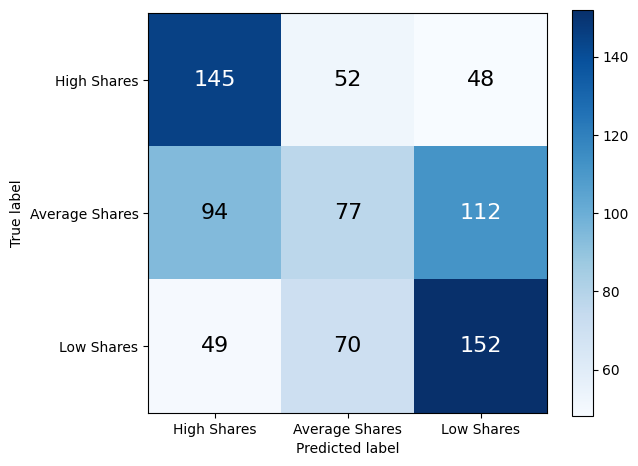

In [10]:
nb_GS = GridSearchCV(
    GaussianNB(), 
    {
        'var_smoothing': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 
    }, 
    n_jobs=multiprocessing.cpu_count())

nb_GS = nb_GS.fit(X_train_scaled, y_train)

nb_best_model = nb_GS.best_estimator_
print(nb_best_model.get_params())

get_mean_cvs(nb_best_model, X_train_scaled, y_train)

nb_best_model.fit(X_train_scaled, y_train)
y_pred_nb_best = nb_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr_best)

In [11]:
pickle.dump(nb_best_model, open('./dataset/Model/nb_best_model.pkl', 'wb'))

# Instance Based

## K-Nearest Neighbours

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Cross Validation Accuracy Score: 0.405 (0.017)
                precision    recall  f1-score   support

   High Shares      0.401     0.516     0.451       283
Average Shares      0.463     0.465     0.464       245
    Low Shares      0.460     0.321     0.378       271

      accuracy                          0.434       799
     macro avg      0.442     0.434     0.431       799
  weighted avg      0.440     0.434     0.431       799



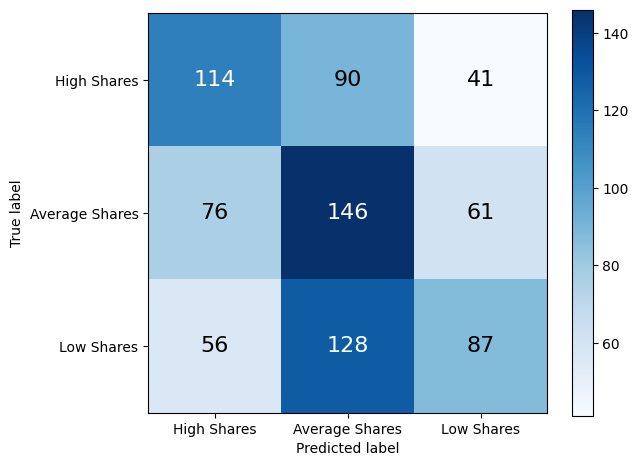

In [12]:
knn_base_model = KNeighborsClassifier()
print(knn_base_model.get_params())

get_mean_cvs(knn_base_model, X_train_scaled, y_train)

knn_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = knn_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 3, 'weights': 'distance'}
Cross Validation Accuracy Score: 0.426 (0.024)
                precision    recall  f1-score   support

   High Shares      0.434     0.438     0.436       283
Average Shares      0.468     0.478     0.473       245
    Low Shares      0.494     0.480     0.487       271

      accuracy                          0.464       799
     macro avg      0.465     0.465     0.465       799
  weighted avg      0.465     0.464     0.464       799



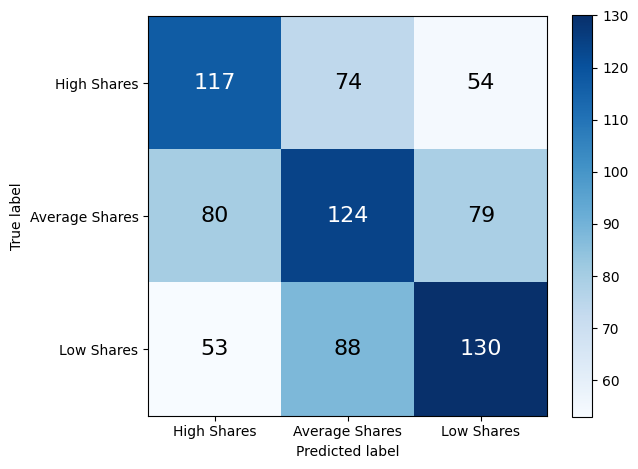

In [13]:
knn_GS = GridSearchCV(
    KNeighborsClassifier(), 
    {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30],
        'p': [1, 2, 3]
    }, 
    n_jobs=multiprocessing.cpu_count())

knn_GS = knn_GS.fit(X_train_scaled, y_train)

knn_best_model = knn_GS.best_estimator_
print(knn_best_model.get_params())

get_mean_cvs(knn_best_model, X_train_scaled, y_train)

knn_best_model.fit(X_train_scaled, y_train)
y_pred_knn_best = knn_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_knn_best)

In [14]:
pickle.dump(knn_best_model, open('./dataset/Model/knn_best_model.pkl', 'wb'))

## Support Vector Machine

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.474 (0.028)
                precision    recall  f1-score   support

   High Shares      0.392     0.353     0.372       283
Average Shares      0.536     0.571     0.553       245
    Low Shares      0.512     0.535     0.523       271

      accuracy                          0.482       799
     macro avg      0.480     0.487     0.483       799
  weighted avg      0.477     0.482     0.479       799



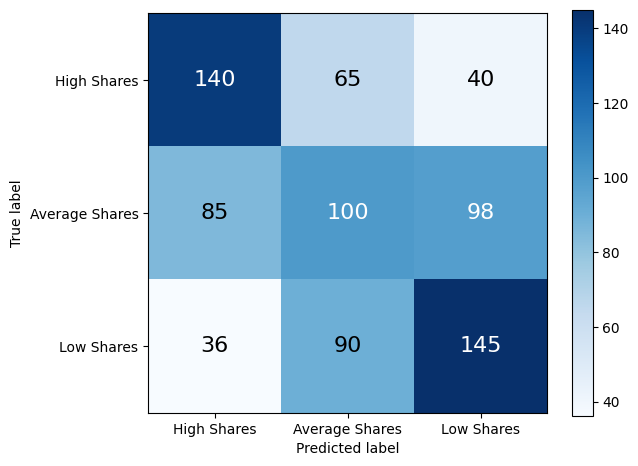

In [15]:
svm_base_model = SVC()
print(svm_base_model.get_params())

get_mean_cvs(svm_base_model, X_train_scaled, y_train)

svm_base_model.fit(X_train_scaled, y_train)
y_pred_cb_base = svm_base_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_cb_base)

{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Accuracy Score: 0.480 (0.023)
                precision    recall  f1-score   support

   High Shares      0.404     0.290     0.337       283
Average Shares      0.509     0.580     0.542       245
    Low Shares      0.492     0.576     0.531       271

      accuracy                          0.476       799
     macro avg      0.468     0.482     0.470       799
  weighted avg      0.466     0.476     0.466       799



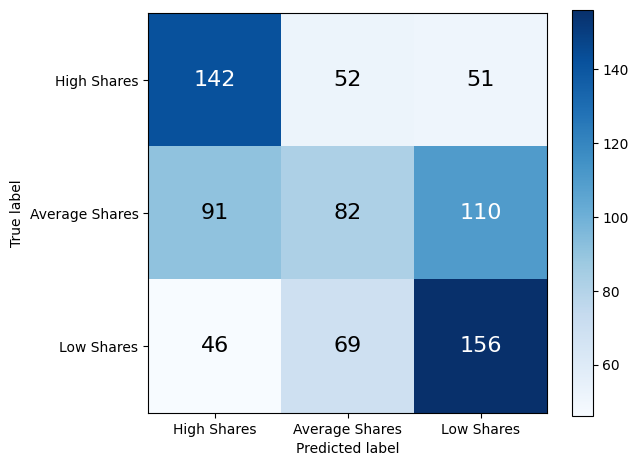

In [16]:
svm_GS = GridSearchCV(
    SVC(), 
    {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto', 0.1, 1]
    }, 
    n_jobs=multiprocessing.cpu_count())

svm_GS = svm_GS.fit(X_train_scaled, y_train)

svm_best_model = svm_GS.best_estimator_
print(svm_best_model.get_params())

get_mean_cvs(svm_best_model, X_train_scaled, y_train)

svm_best_model.fit(X_train_scaled, y_train)
y_pred_svm_best = svm_best_model.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm_best)

In [17]:
pickle.dump(svm_best_model, open('./dataset/Model/svm_best_model.pkl', 'wb'))

# Tree Based

## Random Forest

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2023, 'verbose': 0, 'warm_start': False}
Cross Validation Accuracy Score: 0.473 (0.028)
                precision    recall  f1-score   support

   High Shares      0.384     0.332     0.356       283
Average Shares      0.492     0.514     0.503       245
    Low Shares      0.483     0.531     0.506       271

      accuracy                          0.456       799
     macro avg      0.453     0.459     0.455       799
  weighted avg      0.451     0.456     0.452       799



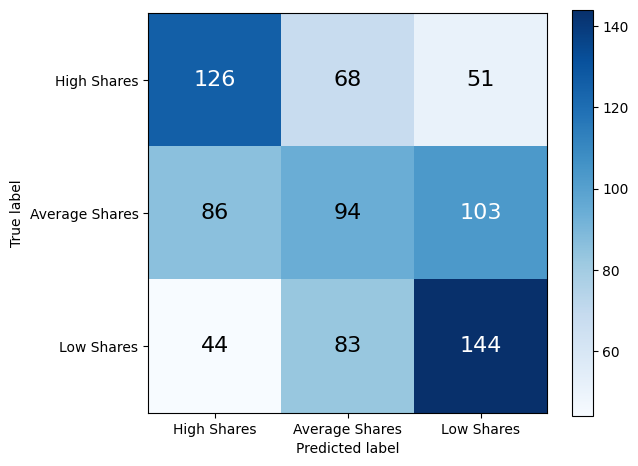

In [30]:
rf_base_model = RandomForestClassifier(
    random_state=rand_state, 
)
print(rf_base_model.get_params())

get_mean_cvs(rf_base_model, X_train, y_train)

rf_base_model.fit(X_train, y_train)
y_pred_cb_base = rf_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=200,
                       random_state=2023)
Cross Validation Accuracy Score: 0.478 (0.023)
                precision    recall  f1-score   support

   High Shares      0.356     0.205     0.260       283
Average Shares      0.468     0.510     0.488       245
    Low Shares      0.461     0.627     0.531       271

      accuracy                          0.442       799
     macro avg      0.428     0.447     0.427       799
  weighted avg      0.426     0.442     0.422       799



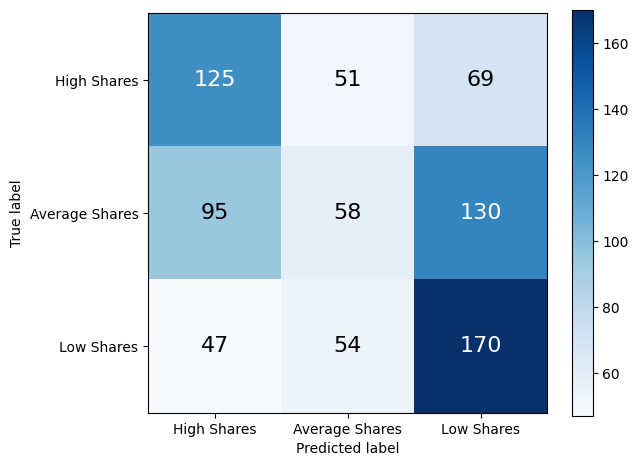

In [31]:
rf_GS = GridSearchCV(
    RandomForestClassifier(random_state=rand_state), 
    {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }, 
    n_jobs=multiprocessing.cpu_count())

rf_GS = rf_GS.fit(X_train, y_train)

rf_best_model = rf_GS.best_estimator_
print(rf_best_model)

get_mean_cvs(rf_best_model, X_train, y_train)

rf_best_model.fit(X_train, y_train)
y_pred_rf_best = rf_best_model.predict(X_test)
evaluate_model(y_test, y_pred_rf_best)

In [20]:
pickle.dump(rf_best_model, open('./dataset/Model/rf_best_model.pkl', 'wb'))

## CatBoost

{'verbose': False, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.471 (0.027)
                precision    recall  f1-score   support

   High Shares      0.360     0.307     0.331       283
Average Shares      0.496     0.555     0.524       245
    Low Shares      0.477     0.498     0.487       271

      accuracy                          0.448       799
     macro avg      0.444     0.454     0.448       799
  weighted avg      0.441     0.448     0.443       799



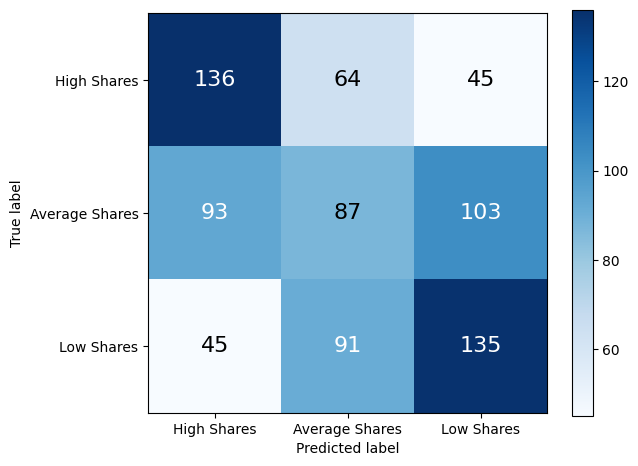

In [21]:
cb_base_model = cb.CatBoostClassifier(
    objective='MultiClass', 
    random_state=rand_state, 
    verbose=False
)
print(cb_base_model.get_params())

get_mean_cvs(cb_base_model, X_train, y_train)

cb_base_model.fit(X_train, y_train, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

{'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3, 'verbose': False, 'n_estimators': 100, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.480 (0.027)
                precision    recall  f1-score   support

   High Shares      0.402     0.276     0.327       283
Average Shares      0.503     0.588     0.542       245
    Low Shares      0.495     0.583     0.536       271

      accuracy                          0.476       799
     macro avg      0.467     0.482     0.468       799
  weighted avg      0.465     0.476     0.464       799



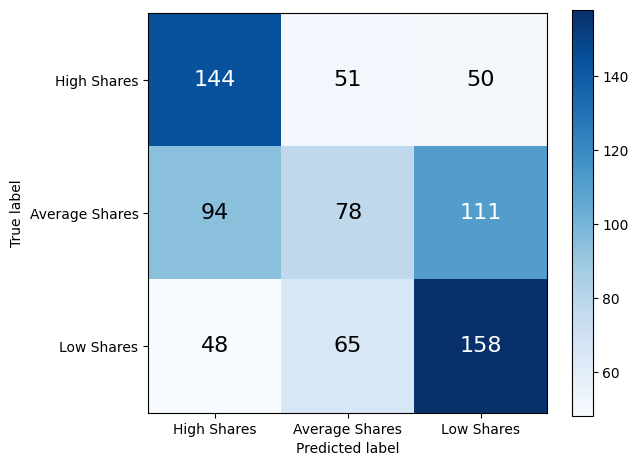

In [22]:
cb_GS = GridSearchCV(
    cb.CatBoostClassifier(objective='MultiClass', random_state=rand_state, verbose=False), 
    {
        'depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'l2_leaf_reg': [1, 3, 5],
    }, 
    n_jobs=multiprocessing.cpu_count())

cb_GS = cb_GS.fit(X_train, y_train)

cb_best_model = cb_GS.best_estimator_
print(cb_best_model.get_params())

get_mean_cvs(cb_best_model, X_train, y_train)

cb_best_model.fit(X_train, y_train)
y_pred_cb_best = cb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_best)

In [23]:
pickle.dump(cb_best_model, open('./dataset/Model/cb_best_model.pkl', 'wb'))

## LightGBM

LGBMClassifier(objective='accuracy', random_state=2023)
Cross Validation Accuracy Score: 0.469 (0.030)
                precision    recall  f1-score   support

   High Shares      0.373     0.322     0.345       283
Average Shares      0.474     0.559     0.513       245
    Low Shares      0.492     0.483     0.488       271

      accuracy                          0.449       799
     macro avg      0.446     0.455     0.449       799
  weighted avg      0.444     0.449     0.445       799



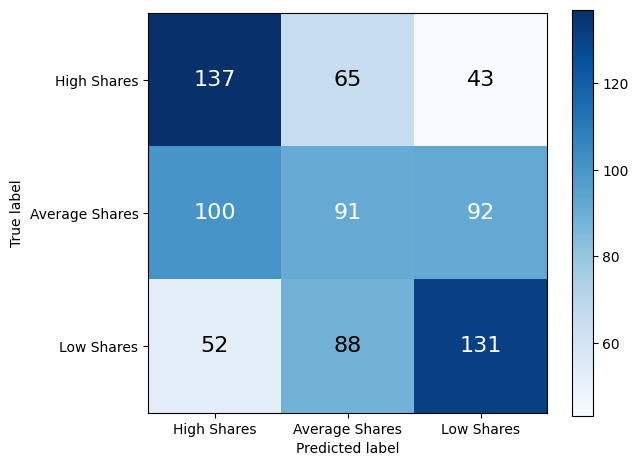

In [24]:
lgb_base_model = lgb.LGBMClassifier(
    objective='accuracy', 
    random_state=rand_state
)
print(lgb_base_model)

get_mean_cvs(lgb_base_model, X_train, y_train)

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_base = lgb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

LGBMClassifier(max_depth=10, n_estimators=60, num_leaves=10,
               objective='accuracy', random_state=2023, subsample=0.5)
Cross Validation Accuracy Score: 0.481 (0.026)
                precision    recall  f1-score   support

   High Shares      0.390     0.325     0.355       283
Average Shares      0.498     0.576     0.534       245
    Low Shares      0.514     0.531     0.523       271

      accuracy                          0.472       799
     macro avg      0.467     0.477     0.470       799
  weighted avg      0.465     0.472     0.467       799



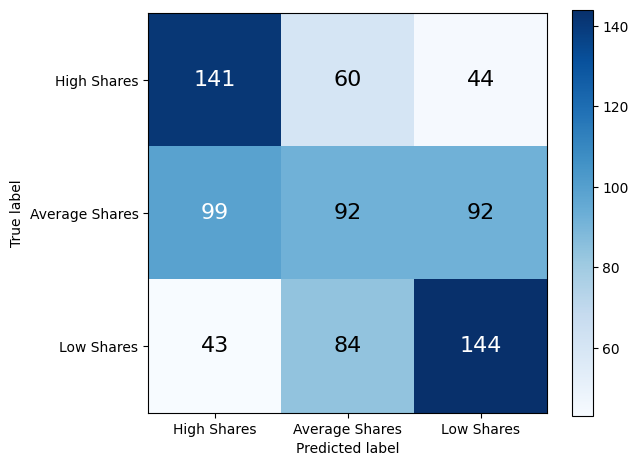

In [25]:
lgb_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', random_state=rand_state), 
    {
        'max_depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 0.9], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lgb_GS = lgb_GS.fit(X_train, y_train)

lgb_best_model = lgb_GS.best_estimator_
print(lgb_best_model)

get_mean_cvs(lgb_best_model, X_train, y_train)

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_best = lgb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_best)

In [26]:
pickle.dump(lgb_best_model, open('./dataset/Model/lgb_best_model.pkl', 'wb'))

## Adaboost

AdaBoostClassifier(random_state=2023)
Cross Validation Accuracy Score: 0.469 (0.026)
                precision    recall  f1-score   support

   High Shares      0.398     0.290     0.335       283
Average Shares      0.481     0.563     0.519       245
    Low Shares      0.493     0.557     0.523       271

      accuracy                          0.464       799
     macro avg      0.457     0.470     0.459       799
  weighted avg      0.456     0.464     0.455       799



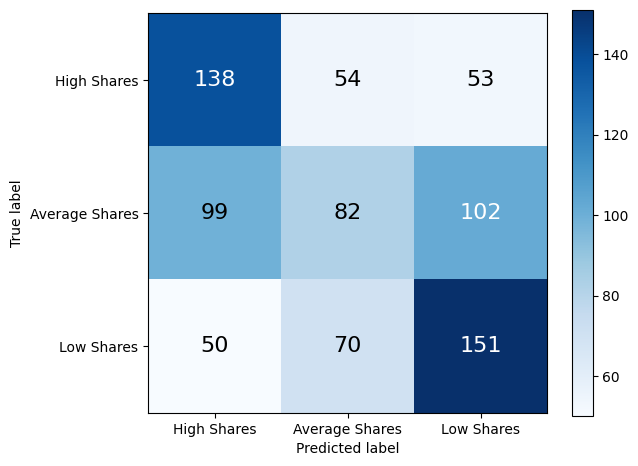

In [27]:
ada_base_model = AdaBoostClassifier(
    random_state=rand_state
)
print(ada_base_model)

get_mean_cvs(ada_base_model, X_train, y_train)

ada_base_model.fit(X_train, y_train)
y_pred_lgb_base = ada_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

AdaBoostClassifier(learning_rate=0.1, n_estimators=150, random_state=2023)
Cross Validation Accuracy Score: 0.483 (0.027)
                precision    recall  f1-score   support

   High Shares      0.380     0.258     0.307       283
Average Shares      0.509     0.571     0.538       245
    Low Shares      0.467     0.572     0.514       271

      accuracy                          0.461       799
     macro avg      0.452     0.467     0.453       799
  weighted avg      0.449     0.461     0.448       799



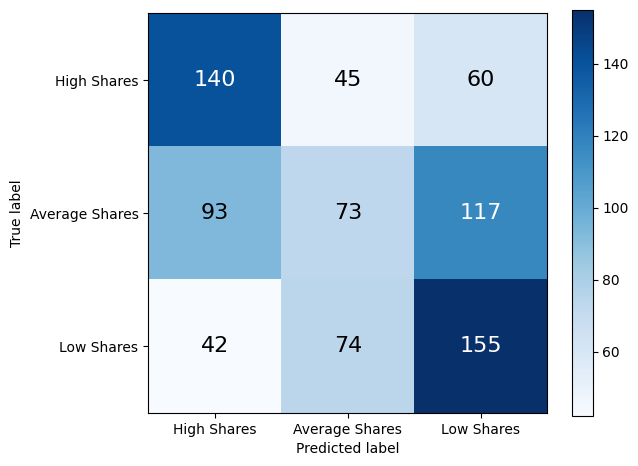

In [28]:
ada_GS = GridSearchCV(
    AdaBoostClassifier(random_state=rand_state), 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }, 
    n_jobs=multiprocessing.cpu_count())

ada_GS = ada_GS.fit(X_train, y_train)

ada_best_model = ada_GS.best_estimator_
print(ada_best_model)

get_mean_cvs(ada_best_model, X_train, y_train)

lgb_base_model.fit(X_train, y_train)
y_pred_ada_best = ada_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ada_best)

In [29]:
pickle.dump(ada_best_model, open('./dataset/Model/ada_best_model.pkl', 'wb'))

# Deep Learning

In [149]:
# Reshape X_train and X_test
X_train_map = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_map = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Map y_train and y_test
mapper = {'Low Shares': 0, 'Average Shares': 1, 'High Shares': 2}
rev_mapper = {value: key for key, value in mapper.items()}
y_train_map = np.vectorize(lambda x: mapper[x])(y_train)
y_test_map = np.vectorize(lambda x: mapper[x])(y_test)

# One-hot encode target variables
y_train_encode = to_categorical(y_train_map)
y_test_encode = to_categorical(y_test_map)

## Convolutional Neural Network

In [150]:
tf.keras.utils.set_random_seed(1)

# Build the model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_map.shape[1], X_train_map.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
cnn_model.add(MaxPooling1D(pool_size=2, padding="same"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_map, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test_map, y_test_encode), workers=multiprocessing.cpu_count())


Epoch 1/25
100/100 [==============================] - 4s 33ms/step - loss: 1.0935 - accuracy: 0.3818 - val_loss: 1.0715 - val_accuracy: 0.3930
Epoch 2/25
100/100 [==============================] - 2s 22ms/step - loss: 1.0646 - accuracy: 0.4215 - val_loss: 1.0618 - val_accuracy: 0.4230
Epoch 3/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0514 - accuracy: 0.4313 - val_loss: 1.0614 - val_accuracy: 0.4380
Epoch 4/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0420 - accuracy: 0.4428 - val_loss: 1.0456 - val_accuracy: 0.4318
Epoch 5/25
100/100 [==============================] - 2s 22ms/step - loss: 1.0387 - accuracy: 0.4519 - val_loss: 1.0513 - val_accuracy: 0.4268
Epoch 6/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0249 - accuracy: 0.4729 - val_loss: 1.0376 - val_accuracy: 0.4531
Epoch 7/25
100/100 [==============================] - 2s 21ms/step - loss: 1.0224 - accuracy: 0.4682 - val_loss: 1.0411 - val_accuracy: 0.4293

25/25 [==============================] - 0s 5ms/step
                precision    recall  f1-score   support

   High Shares      0.361     0.410     0.384       283
Average Shares      0.494     0.478     0.485       245
    Low Shares      0.523     0.465     0.492       271

      accuracy                          0.449       799
     macro avg      0.459     0.451     0.454       799
  weighted avg      0.457     0.449     0.452       799



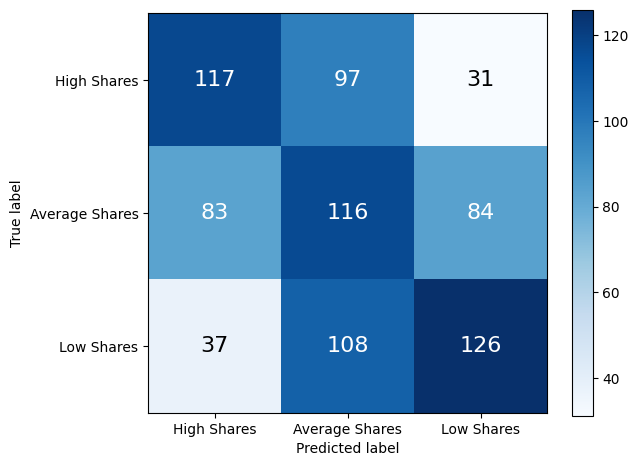

In [151]:
y_pred_cnn = cnn_model.predict(X_test_map)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred_cnn = np.vectorize(lambda x: rev_mapper[x])(y_pred_cnn)

y_test_cnn = np.argmax(y_test_encode, axis=1)
y_test_cnn = np.vectorize(lambda x: rev_mapper[x])(y_test_cnn)

evaluate_model(y_test_cnn, y_pred_cnn)

# Model Evaluation